In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BASE_DIR = r"C:\Users\basma\Documents\chest_xray"  # le r'' permet les chemins Windows

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

# 1) Configurer l'ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# 2) Créer le générateur d'images
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode='binary',  # 'categorical' si multi-classes
    batch_size=32
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [2]:
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
163/163 [==============================] - 191s 1s/step - loss: 0.4190 - accuracy: 0.8259 - val_loss: 0.5227 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 142s 866ms/step - loss: 0.2623 - accuracy: 0.8886 - val_loss: 0.4471 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 140s 858ms/step - loss: 0.2343 - accuracy: 0.9076 - val_loss: 0.3809 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 126s 771ms/step - loss: 0.2150 - accuracy: 0.9151 - val_loss: 0.3806 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 126s 772ms/step - loss: 0.2062 - accuracy: 0.9153 - val_loss: 0.6595 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 125s 767ms/step - loss: 0.1961 - accuracy: 0.9291 - val_loss: 0.5873 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 128s 787ms/step - loss: 0.1681 - accuracy: 0.9329 - val_loss: 0.5962 - va

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Charger ResNet50 pré-entraîné sur ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Geler les couches existantes
for layer in base_model.layers:
    layer.trainable = False

# Ajouter un “top” personnalisé
x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)


94765736/94765736 [==============================] - 7s 0us/step
Epoch 1/5
163/163 [==============================] - 180s 1s/step - loss: 0.9251 - accuracy: 0.7270 - val_loss: 0.6625 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 170s 1s/step - loss: 0.5193 - accuracy: 0.7429 - val_loss: 0.6643 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 170s 1s/step - loss: 0.5379 - accuracy: 0.7429 - val_loss: 0.8032 - val_accuracy: 0.5000
Epoch 4/5
163/163 [==============================] - 170s 1s/step - loss: 0.5129 - accuracy: 0.7429 - val_loss: 0.6736 - val_accuracy: 0.5000
Epoch 5/5
163/163 [==============================] - 169s 1s/step - loss: 0.5097 - accuracy: 0.7429 - val_loss: 0.7491 - val_accuracy: 0.5000


In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


Found 624 images belonging to 2 classes.
20/20 [==============================] - 20s 966ms/step - loss: 0.5305 - accuracy: 0.6250
Test loss: 0.5305339694023132
Test accuracy: 0.625


In [5]:
model.save("pneumonia_detection_model.h5")

C:\Users\basma\anaconda3\envs\pneumonia_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1) Définir les chemins (dataset identique)
BASE_DIR = r"C:\Users\basma\Documents\chest_xray"
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

# 2) Configuration d’une augmentation de données avancée
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # + de rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,          # plus de zoom
    shear_range=0.1,         # cisaillage
    brightness_range=[0.8, 1.2],  # variations de luminosité
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)

# 3) Charger ResNet50 pré-entraîné (sans la top-classification)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# 4) Geler partiellement les couches (fine-tuning)
# On garde les ~150 premières couches gelées et on rend entraînables les dernières.
# (ResNet50 a ~175 couches. Ajustez le 'range' en fonction de l’architecture exacte).
for layer in base_model.layers[:150]:
    layer.trainable = False
for layer in base_model.layers[150:]:
    layer.trainable = True

# 5) Construire la "tête" personnalisée
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# 6) Compiler avec un learning rate réduit pour éviter de trop modifier les poids pré-entraînés
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 7) Mettre en place les callbacks pour stopper tôt et réduire le LR
early_stop = EarlyStopping(
    monitor='val_loss',   # on surveille la loss de validation
    patience=5,           # si ça ne s'améliore pas pendant 5 epochs, on arrête
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           # on divise le learning rate par 2
    patience=2,           # si ça ne s'améliore pas pendant 2 epochs
    min_lr=1e-7
)

# 8) Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# 9) Évaluer sur le jeu de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss :", test_loss)
print("Test Accuracy :", test_acc)

# 10) Sauvegarder le modèle si besoin
model.save("pneumonia_detection_model_finetuned.h5")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/50
163/163 [==============================] - 254s 2s/step - loss: 0.3883 - accuracy: 0.8305 - val_loss: 1.4228 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 2/50
163/163 [==============================] - 250s 2s/step - loss: 0.2723 - accuracy: 0.8796 - val_loss: 0.7937 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 3/50
163/163 [==============================] - 253s 2s/step - loss: 0.2462 - accuracy: 0.9011 - val_loss: 1.1977 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 4/50
163/163 [==============================] - 251s 2s/step - loss: 0.2348 - accuracy: 0.8982 - val_loss: 0.4047 - val_accuracy: 0.8125 - lr: 1.0000e-05
Epoch 5/50
163/163 [==============================] - 251s 2s/step - loss: 0.2274 - accuracy: 0.9011 - val_loss: 0.4783 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 6/50
163/163 [==============================] - 251s 2s/step - loss: 0.2229 - accuracy: 0.9061 - val_loss: 0.670

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Récupérer les prédictions brutes
Y_pred = model.predict(test_generator)
# Convertir proba -> classes (seuil 0.5)
y_pred = (Y_pred > 0.5).astype(int)

# Récupérer les vraies étiquettes
y_true = test_generator.classes  # correspond aux labels du directory

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

print("Classification Report")
print(classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA']))


20/20 [==============================] - 22s 1s/step
Confusion Matrix
[[201  33]
 [ 59 331]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.77      0.86      0.81       234
   PNEUMONIA       0.91      0.85      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.85      0.85       624
weighted avg       0.86      0.85      0.85       624



Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Epoch 1/50
147/147 [==============================] - 320s 2s/step - loss: 0.4248 - accuracy: 0.8162 - val_loss: 0.7111 - val_accuracy: 0.7428 - lr: 1.0000e-05
Epoch 2/50
147/147 [==============================] - 308s 2s/step - loss: 0.3089 - accuracy: 0.8656 - val_loss: 0.3935 - val_accuracy: 0.7486 - lr: 1.0000e-05
Epoch 3/50
147/147 [==============================] - 309s 2s/step - loss: 0.2516 - accuracy: 0.8886 - val_loss: 0.3319 - val_accuracy: 0.8273 - lr: 1.0000e-05
Epoch 4/50
147/147 [==============================] - 307s 2s/step - loss: 0.2462 - accuracy: 0.8948 - val_loss: 0.2343 - val_accuracy: 0.8791 - lr: 1.0000e-05
Epoch 5/50
147/147 [==============================] - 307s 2s/step - loss: 0.2242 - accuracy: 0.9082 - val_loss: 0.2043 - val_accuracy: 0.9098 - lr: 1.0000e-05
Epoch 6/50
147/147 [==============================] - 306s 2s/step - loss: 0.2275 - accuracy: 0.8993 - val_loss: 0.43

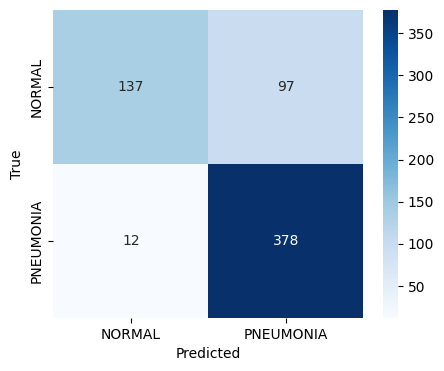

C:\Users\basma\anaconda3\envs\pneumonia_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Pour la matrice de confusion et le rapport de classification
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 1) Chemins vers vos données
# -------------------------------------------------------------------
BASE_DIR = r"C:\Users\basma\Documents\chest_xray"
train_dir = os.path.join(BASE_DIR, "train")
test_dir  = os.path.join(BASE_DIR, "test")

# -------------------------------------------------------------------
# 2) Data Augmentation avancée + validation_split
# -------------------------------------------------------------------
# On va prendre TOUT depuis 'train_dir' (qui contient Normal/Pneumonia)
# et on alloue 10 % des images pour la validation.
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,   # 10% pour val
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# -------------------------------------------------------------------
# 3) Générateurs d'images : Train & Validation
# -------------------------------------------------------------------
train_generator = train_val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    subset='training'
)

val_generator = train_val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    subset='validation'
)

# -------------------------------------------------------------------
# 4) Charger un modèle pré-entraîné (ResNet50) pour le fine-tuning partiel
# -------------------------------------------------------------------
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Geler partiellement : par ex. 120 premières couches gelées
for layer in base_model.layers[:120]:
    layer.trainable = False
for layer in base_model.layers[120:]:
    layer.trainable = True

# -------------------------------------------------------------------
# 5) Construire la tête personnalisée
# -------------------------------------------------------------------
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# -------------------------------------------------------------------
# 6) Compiler (learning_rate réduit pour fine-tuning)
# -------------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# (Optionnel) Si vous avez un déséquilibre de classes,
# vous pouvez définir un class_weight, par ex.:
# class_weight = {0: 1.0, 1: 1.0}
# model.fit(..., class_weight=class_weight)

# -------------------------------------------------------------------
# 7) Callbacks : EarlyStopping & ReduceLROnPlateau
# -------------------------------------------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)

# -------------------------------------------------------------------
# 8) Entraînement
# -------------------------------------------------------------------
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# -------------------------------------------------------------------
# 9) Évaluation sur le set de test (dossier séparé)
# -------------------------------------------------------------------
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss :", test_loss)
print("Test Accuracy :", test_acc)

# -------------------------------------------------------------------
# 10) Matrice de confusion + classification report
# -------------------------------------------------------------------
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

print("Classification Report")
labels = list(test_generator.class_indices.keys())  # ex ['NORMAL','PNEUMONIA']
print(classification_report(y_true, y_pred, target_names=labels))

# Visualisation heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------------------------------------------------
# 11) Sauvegarder le modèle (optionnel)
# -------------------------------------------------------------------
model.save("pneumonia_detection_model_finetuned.h5")


In [10]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Epoch 1/50
147/147 [==============================] - 317s 2s/step - loss: 0.3746 - accuracy: 0.8407 - val_loss: 0.6172 - val_accuracy: 0.7428 - lr: 1.0000e-05
Epoch 2/50
147/147 [==============================] - 311s 2s/step - loss: 0.2906 - accuracy: 0.8711 - val_loss: 0.3260 - val_accuracy: 0.8503 - lr: 1.0000e-05
Epoch 3/50
147/147 [==============================] - 311s 2s/step - loss: 0.2649 - accuracy: 0.8848 - val_loss: 0.4999 - val_accuracy: 0.7889 - lr: 1.0000e-05
Epoch 4/50
147/147 [==============================] - 310s 2s/step - loss: 0.2433 - accuracy: 0.8912 - val_loss: 0.2242 - val_accuracy: 0.8868 - lr: 1.0000e-05
Epoch 5/50
147/147 [==============================] - 312s 2s/step - loss: 0.2162 - accuracy: 0.9118 - val_loss: 0.2365 - val_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 6/50
147/147 [==============================] - 310s 2s/step - loss: 0.2183 - accuracy: 0.9097 - val_loss: 0.28

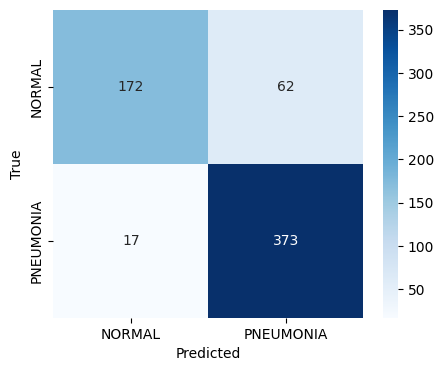

C:\Users\basma\anaconda3\envs\pneumonia_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Pour la matrice de confusion et le rapport de classification
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 1) Chemins vers vos données
# -------------------------------------------------------------------
BASE_DIR = r"C:\Users\basma\Documents\chest_xray"
train_dir = os.path.join(BASE_DIR, "train")
test_dir  = os.path.join(BASE_DIR, "test")

# -------------------------------------------------------------------
# 2) Data Augmentation avancée + validation_split
# -------------------------------------------------------------------
# On va prendre TOUT depuis 'train_dir' (qui contient Normal/Pneumonia)
# et on alloue 10 % des images pour la validation.
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,   # 10% pour val
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# -------------------------------------------------------------------
# 3) Générateurs d'images : Train & Validation
# -------------------------------------------------------------------
train_generator = train_val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    subset='training'
)

val_generator = train_val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    subset='validation'
)

# -------------------------------------------------------------------
# 4) Charger un modèle pré-entraîné (ResNet50) pour le fine-tuning partiel
# -------------------------------------------------------------------
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Geler partiellement : par ex. 120 premières couches gelées
for layer in base_model.layers[:120]:
    layer.trainable = False
for layer in base_model.layers[120:]:
    layer.trainable = True

# -------------------------------------------------------------------
# 5) Construire la tête personnalisée
# -------------------------------------------------------------------
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# -------------------------------------------------------------------
# 6) Compiler (learning_rate réduit pour fine-tuning)
# -------------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# (Optionnel) Si vous avez un déséquilibre de classes,
# vous pouvez définir un class_weight, par ex.:
# class_weight = {0: 1.0, 1: 1.0}
# model.fit(..., class_weight=class_weight)

# -------------------------------------------------------------------
# 7) Callbacks : EarlyStopping & ReduceLROnPlateau
# -------------------------------------------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)

# -------------------------------------------------------------------
# 8) Entraînement
# -------------------------------------------------------------------
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# -------------------------------------------------------------------
# 9) Évaluation sur le set de test (dossier séparé)
# -------------------------------------------------------------------
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss :", test_loss)
print("Test Accuracy :", test_acc)

# -------------------------------------------------------------------
# 10) Matrice de confusion + classification report
# -------------------------------------------------------------------
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

print("Classification Report")
labels = list(test_generator.class_indices.keys())  # ex ['NORMAL','PNEUMONIA']
print(classification_report(y_true, y_pred, target_names=labels))

# Visualisation heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------------------------------------------------
# 11) Sauvegarder le modèle (optionnel)
# -------------------------------------------------------------------
model.save("pneumonia_detection_model_finetuned.h5")


In [12]:
model.save("pneumonia_detection_model_finetuned.keras")

In [13]:
pip install tf-explain

1/1 [==============================] - 1s 655ms/step


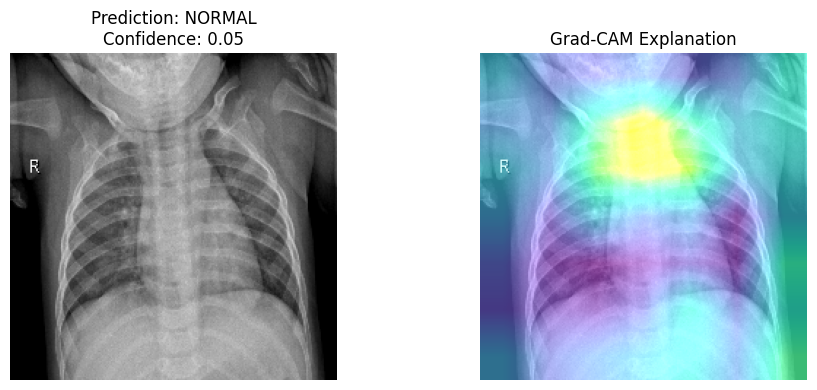

1/1 [==============================] - 0s 78ms/step


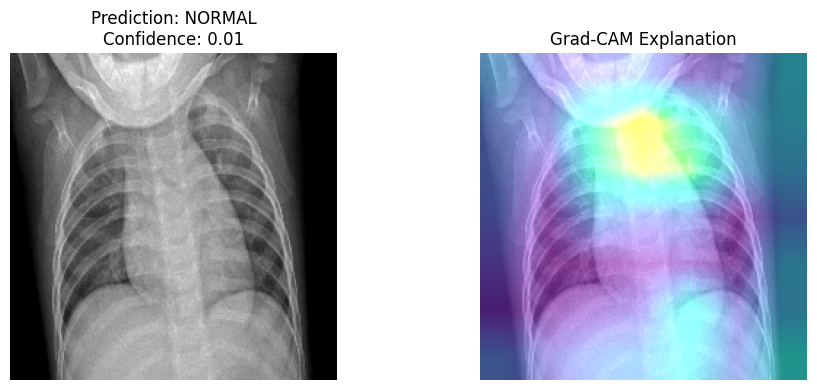

1/1 [==============================] - 0s 78ms/step


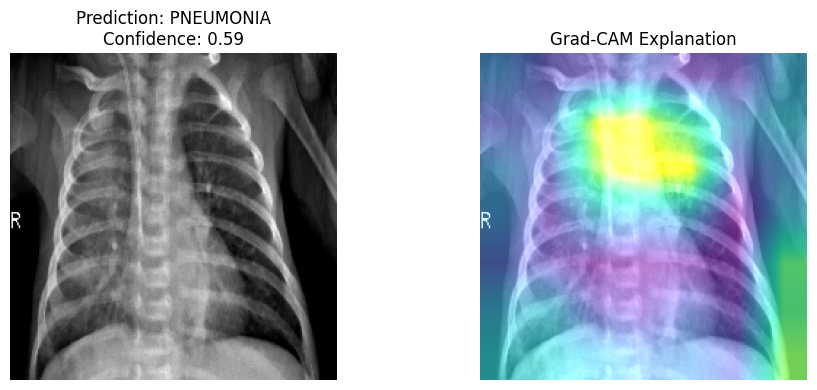

1/1 [==============================] - 0s 75ms/step


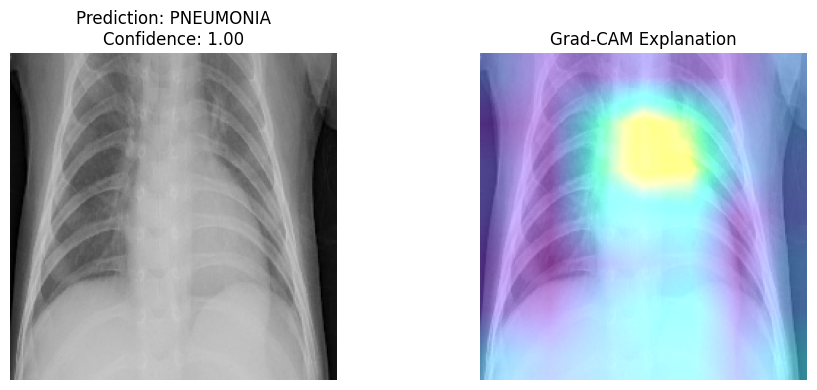

1/1 [==============================] - 0s 76ms/step


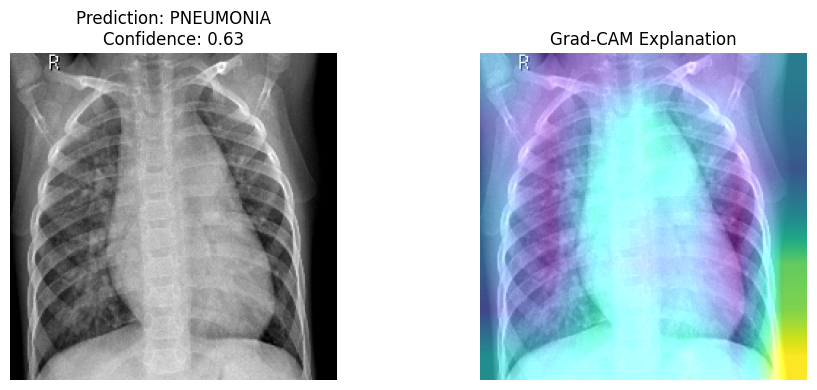

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tf_explain.core.grad_cam import GradCAM

###############################################
# FONCTIONS DE PRÉDICTION & EXPLICATION
###############################################

def predict_image_with_explanation(model, img_path, last_conv_layer_name, threshold=0.5):
    """
    Charge une image, fait la prédiction, et génère une carte Grad-CAM
    pour montrer où le réseau se focalise.
    
    - model : modèle Keras déjà chargé
    - img_path : chemin vers l'image
    - last_conv_layer_name : nom de la dernière couche conv à visualiser (Grad-CAM)
    - threshold : seuil de décision (0.5 par défaut)
    """
    # 1) Charger et redimensionner l'image à 224x224
    orig_img = image.load_img(img_path, target_size=(224, 224))
    
    # 2) Convertir en tableau numpy (et normaliser)
    img_array = image.img_to_array(orig_img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)  # => shape (1, 224, 224, 3)
    
    # 3) Prédiction
    prob = model.predict(img_array_expanded)[0][0]  # résultat sigmoid
    predicted_label = "PNEUMONIA" if prob >= threshold else "NORMAL"

    # 4) Grad-CAM
    # On crée des données formatées pour tf-explain
    data = (img_array_expanded, None)
    explainer = GradCAM()

    # class_index=0 car le modèle a 1 seule sortie (sigmoid).
    # On indique la couche conv finale sur laquelle on calcule la heatmap.
    cam = explainer.explain(
        data,
        model,
        class_index=0,
        layer_name=last_conv_layer_name
    )
    # 'cam' est une heatmap superposée sur l'image d'origine (array Numpy)
    
    return predicted_label, prob, cam


def visualize_prediction(img_path, predicted_label, prob, cam):
    """
    Affiche:
      - À gauche: l'image originale + la prédiction
      - À droite: la carte Grad-CAM (heatmap) superposée
    """
    # Figure 1 x 2
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # 1) Image originale + titre
    axes[0].imshow(image.load_img(img_path, target_size=(224, 224)))
    axes[0].set_title(f"Prediction: {predicted_label}\nConfidence: {prob:.2f}")
    axes[0].axis('off')

    # 2) Carte Grad-CAM
    axes[1].imshow(cam)
    axes[1].set_title("Grad-CAM Explanation")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


###############################################
# SCRIPT PRINCIPAL
###############################################
if __name__ == "__main__":
    # 1) Chemin vers le modèle
    model_path = "pneumonia_detection_model_finetuned.h5"
    model = tf.keras.models.load_model(model_path)

    # 2) Identifier la couche de convolution finale pour Grad-CAM
    # Pour ResNet50, souvent "conv5_block3_out"
    # Vous pouvez vérifier en listant les couches :
    # for i, layer in enumerate(model.layers):
    #     print(i, layer.name, layer.output_shape)
    last_conv_layer_name = "conv5_block3_out"

    # 3) Dossier contenant vos images de test
    images_folder = r"C:\Users\basma\Documents\chest_xray\test_images"

    # 4) Lister les fichiers d'images
    valid_extensions = {".jpg", ".jpeg", ".png"}
    image_files = [f for f in os.listdir(images_folder)
                   if os.path.splitext(f)[1].lower() in valid_extensions]

    # 5) Boucler sur chaque image et prédire
    for img_name in image_files:
        img_path = os.path.join(images_folder, img_name)
        
        # Prédiction + génération de la heatmap Grad-CAM
        predicted_label, prob, cam = predict_image_with_explanation(
            model,
            img_path,
            last_conv_layer_name=last_conv_layer_name,
            threshold=0.5  # seuil de décision
        )

        # Affichage
        visualize_prediction(img_path, predicted_label, prob, cam)

        # Si vous voulez seulement afficher un résumé en console :
        # print(f"{img_name} -> {predicted_label} (score: {prob:.2f})")


1/1 [==============================] - 1s 660ms/step


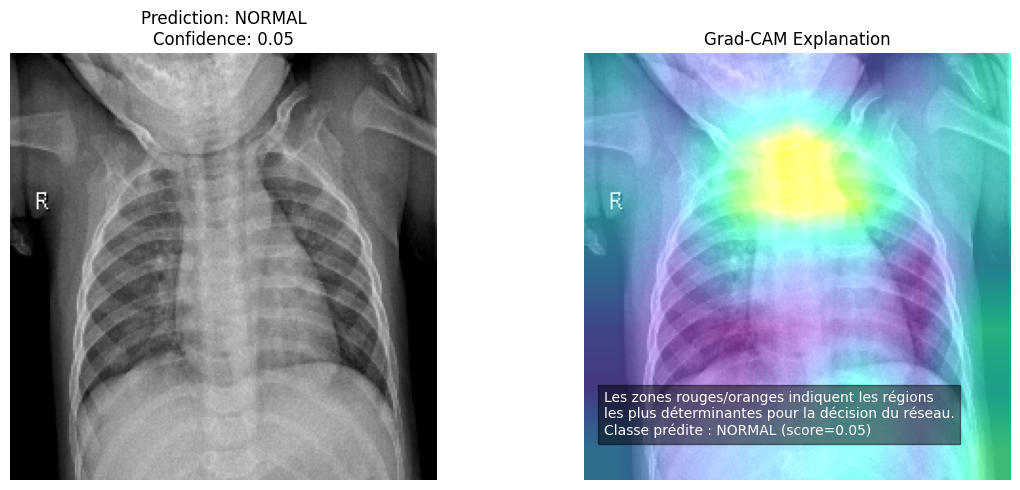

[INFO] IM-0131-0001.jpeg: l'image est jugée normale (score=0.05).
1/1 [==============================] - 0s 81ms/step


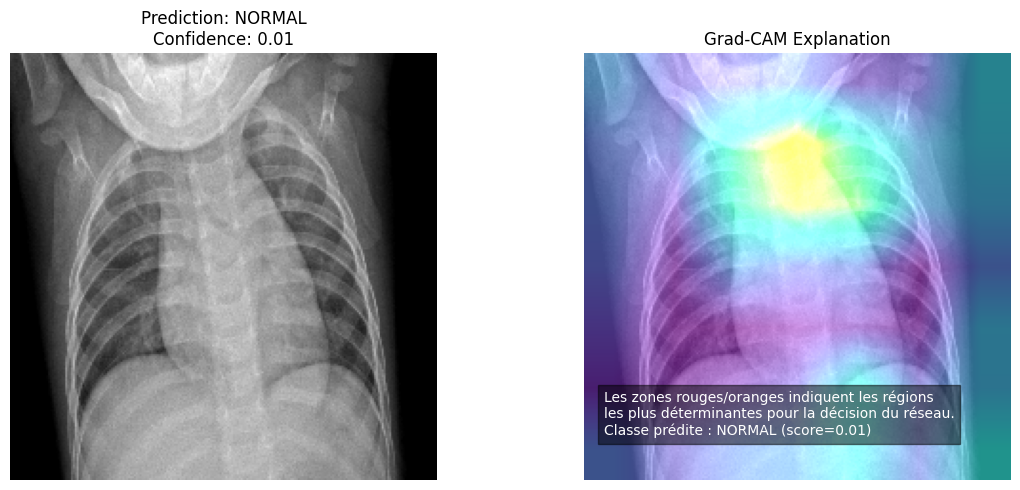

[INFO] IM-0133-0001.jpeg: l'image est jugée normale (score=0.01).
1/1 [==============================] - 0s 75ms/step


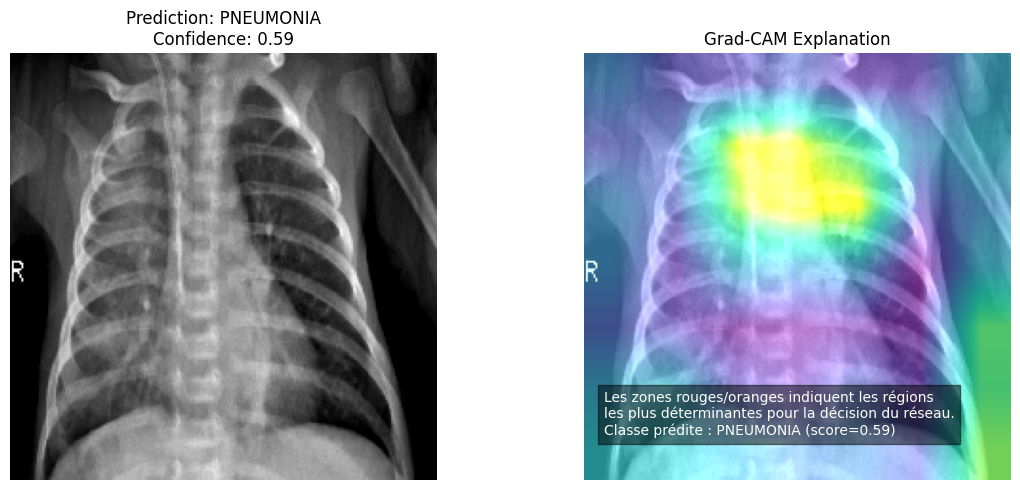

[INFO] person10_bacteria_43.jpeg: le modèle détecte potentiellement une pneumonie avec une confiance de 0.59.
1/1 [==============================] - 0s 75ms/step


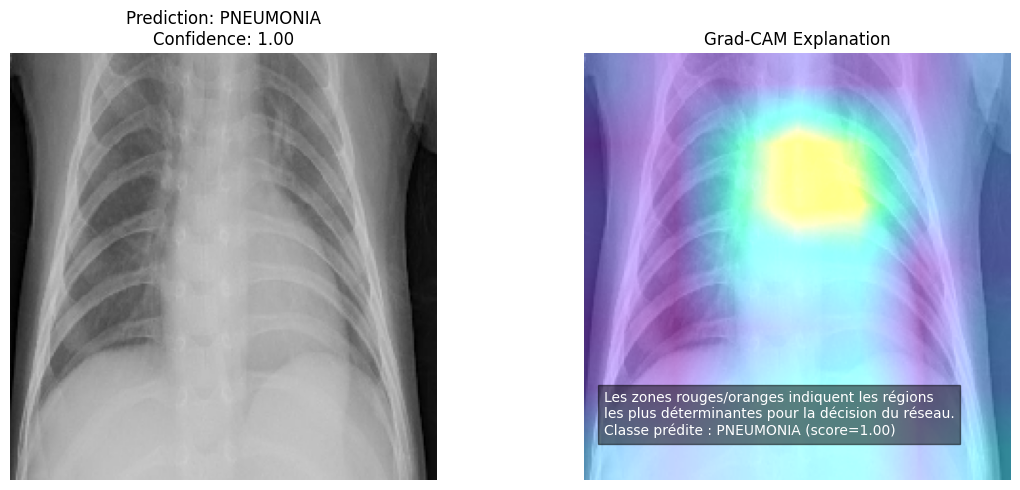

[INFO] person11_bacteria_45.jpeg: le modèle détecte potentiellement une pneumonie avec une confiance de 1.00.
1/1 [==============================] - 0s 80ms/step


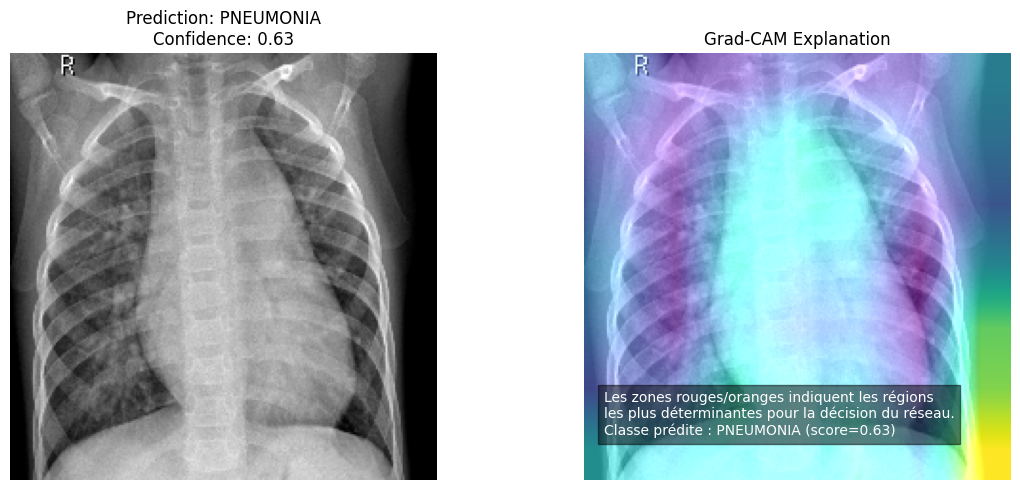

[INFO] person12_bacteria_46.jpeg: le modèle détecte potentiellement une pneumonie avec une confiance de 0.63.


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tf_explain.core.grad_cam import GradCAM

###############################################
# FONCTIONS DE PRÉDICTION & EXPLICATION
###############################################

def predict_image_with_explanation(model, img_path, last_conv_layer_name, threshold=0.5):
    """
    Charge une image, fait la prédiction, et génère une carte Grad-CAM
    pour montrer où le réseau se focalise.
    
    - model : modèle Keras déjà chargé
    - img_path : chemin vers l'image
    - last_conv_layer_name : nom de la dernière couche conv à visualiser (Grad-CAM)
    - threshold : seuil de décision (0.5 par défaut)
    """
    # 1) Charger et redimensionner l'image à 224x224
    orig_img = image.load_img(img_path, target_size=(224, 224))
    
    # 2) Convertir en tableau numpy (et normaliser)
    img_array = image.img_to_array(orig_img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)  # => shape (1, 224, 224, 3)
    
    # 3) Prédiction
    prob = model.predict(img_array_expanded)[0][0]  # résultat sigmoid
    predicted_label = "PNEUMONIA" if prob >= threshold else "NORMAL"

    # 4) Grad-CAM
    # On crée des données formatées pour tf-explain
    data = (img_array_expanded, None)
    explainer = GradCAM()

    # class_index=0 car le modèle a 1 seule sortie (sigmoid).
    # On indique la couche conv finale sur laquelle on calcule la heatmap.
    cam = explainer.explain(
        data,
        model,
        class_index=0,
        layer_name=last_conv_layer_name
    )
    # 'cam' est une heatmap superposée sur l'image d'origine (array Numpy)
    
    return predicted_label, prob, cam


def visualize_prediction(img_path, predicted_label, prob, cam):
    """
    Affiche:
      - À gauche: l'image originale + la prédiction
      - À droite: la carte Grad-CAM (heatmap) superposée
      - Ajoute un texte explicatif sur la seconde figure
    """
    # Figure 1 x 2
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1) Image originale + titre
    axes[0].imshow(image.load_img(img_path, target_size=(224, 224)))
    axes[0].set_title(f"Prediction: {predicted_label}\nConfidence: {prob:.2f}")
    axes[0].axis('off')

    # 2) Carte Grad-CAM
    axes[1].imshow(cam)
    # Titre principal
    axes[1].set_title("Grad-CAM Explanation")
    axes[1].axis('off')
    
    # 2.b) Ajouter un texte explicatif
    # On place un petit texte en bas à gauche (x=10, y=210 par ex.)
    explanation_text = (
        "Les zones rouges/oranges indiquent les régions\n"
        "les plus déterminantes pour la décision du réseau.\n"
        f"Classe prédite : {predicted_label} (score={prob:.2f})"
    )
    axes[1].text(
        10, 200, explanation_text,
        fontsize=10, color='white',
        bbox=dict(facecolor='black', alpha=0.5)  # fond semi-transparent
    )

    plt.tight_layout()
    plt.show()


###############################################
# SCRIPT PRINCIPAL
###############################################
if __name__ == "__main__":
    # 1) Chemin vers le modèle
    model_path = "pneumonia_detection_model_finetuned.h5"
    model = tf.keras.models.load_model(model_path)

    # 2) Identifier la couche de convolution finale pour Grad-CAM
    last_conv_layer_name = "conv5_block3_out"

    # 3) Dossier contenant vos images de test
    images_folder = r"C:\Users\basma\Documents\chest_xray\test_images"

    # 4) Lister les fichiers d'images
    valid_extensions = {".jpg", ".jpeg", ".png"}
    image_files = [f for f in os.listdir(images_folder)
                   if os.path.splitext(f)[1].lower() in valid_extensions]

    # 5) Boucler sur chaque image et prédire
    for img_name in image_files:
        img_path = os.path.join(images_folder, img_name)
        
        # Prédiction + génération de la heatmap Grad-CAM
        predicted_label, prob, cam = predict_image_with_explanation(
            model,
            img_path,
            last_conv_layer_name=last_conv_layer_name,
            threshold=0.5  # seuil de décision
        )

        # Affichage (figure + texte)
        visualize_prediction(img_path, predicted_label, prob, cam)

        # 6) Commentaire dans la console (exemple)
        #    Vous pouvez personnaliser le message si nécessaire :
        if predicted_label == "PNEUMONIA":
            print(f"[INFO] {img_name}: le modèle détecte potentiellement une pneumonie "
                  f"avec une confiance de {prob:.2f}.")
        else:
            print(f"[INFO] {img_name}: l'image est jugée normale (score={prob:.2f}).")


1/1 [==============================] - 1s 794ms/step
[INFO] Figure sauvegardée en PDF: IM-0131-0001_result.pdf


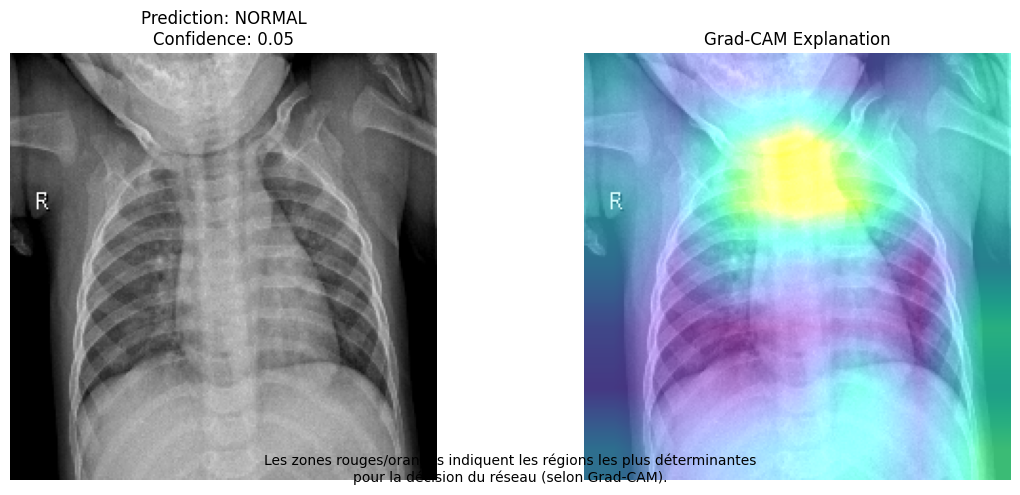

[INFO] IM-0131-0001.jpeg -> NORMAL (score = 0.05)

1/1 [==============================] - 0s 81ms/step
[INFO] Figure sauvegardée en PDF: IM-0133-0001_result.pdf


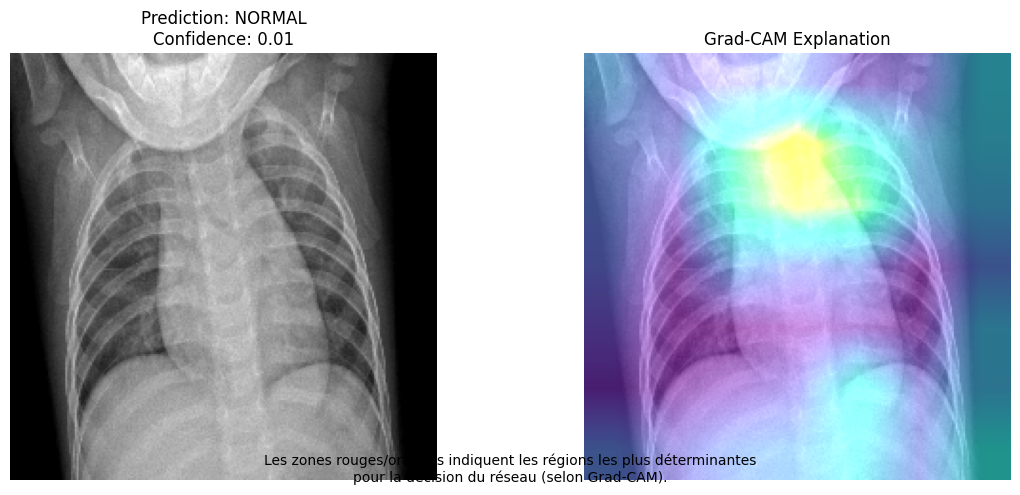

[INFO] IM-0133-0001.jpeg -> NORMAL (score = 0.01)

1/1 [==============================] - 0s 81ms/step
[INFO] Figure sauvegardée en PDF: person10_bacteria_43_result.pdf


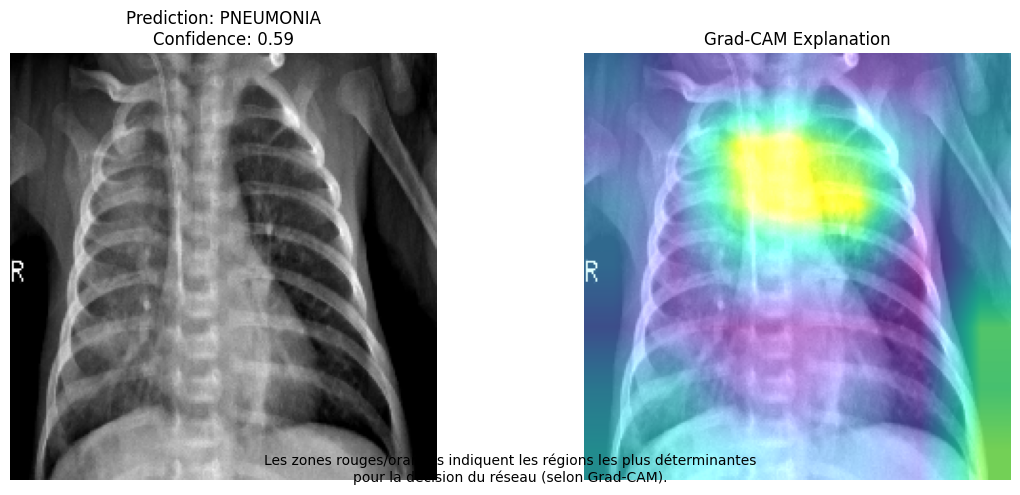

[INFO] person10_bacteria_43.jpeg -> PNEUMONIA (score = 0.59)

1/1 [==============================] - 0s 72ms/step
[INFO] Figure sauvegardée en PDF: person11_bacteria_45_result.pdf


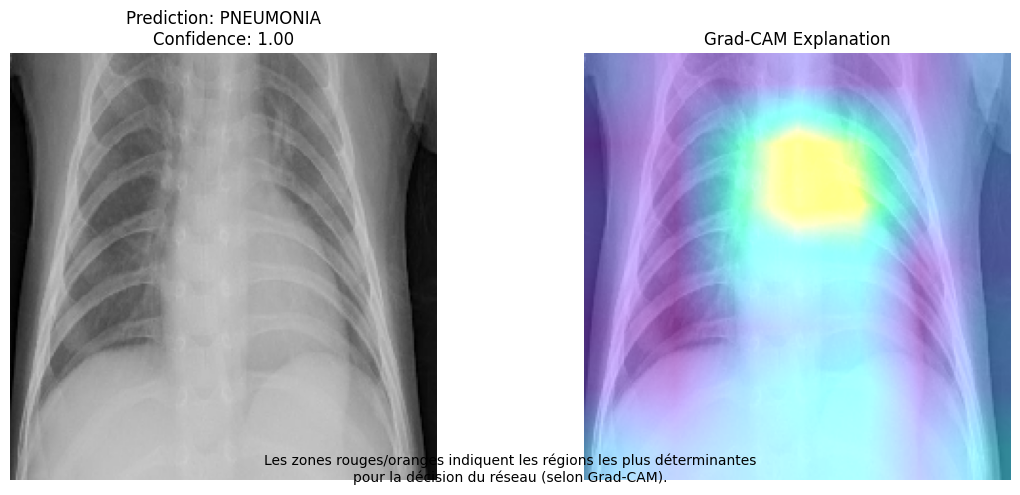

[INFO] person11_bacteria_45.jpeg -> PNEUMONIA (score = 1.00)

1/1 [==============================] - 0s 76ms/step
[INFO] Figure sauvegardée en PDF: person12_bacteria_46_result.pdf


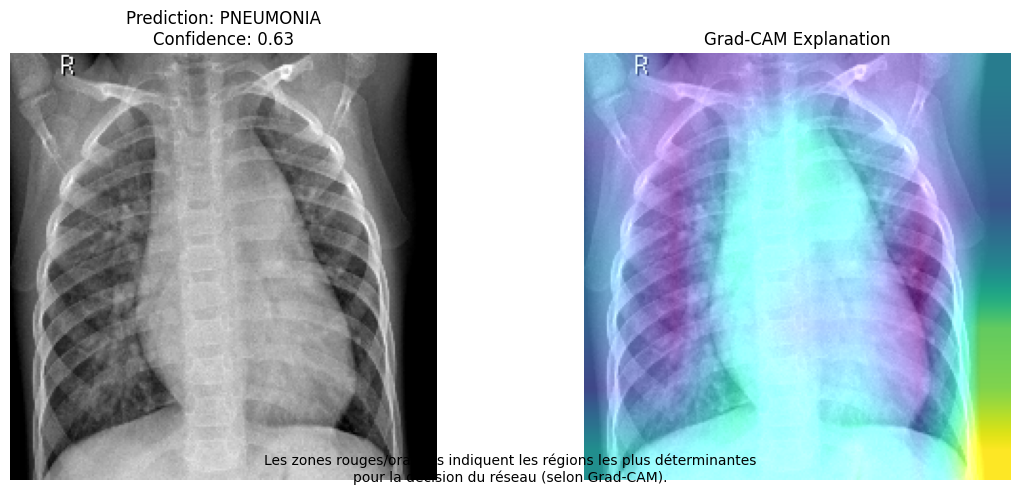

[INFO] person12_bacteria_46.jpeg -> PNEUMONIA (score = 0.63)



In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tf_explain.core.grad_cam import GradCAM

###############################################
# FONCTIONS DE PRÉDICTION & EXPLICATION
###############################################

def predict_image_with_explanation(model, img_path, last_conv_layer_name, threshold=0.5):
    """
    Charge une image, fait la prédiction, et génère une carte Grad-CAM
    pour montrer où le réseau se focalise.
    
    - model : modèle Keras déjà chargé
    - img_path : chemin vers l'image
    - last_conv_layer_name : nom de la dernière couche conv à visualiser (Grad-CAM)
    - threshold : seuil de décision (0.5 par défaut)
    """
    # 1) Charger et redimensionner l'image à 224x224
    orig_img = image.load_img(img_path, target_size=(224, 224))
    
    # 2) Convertir en tableau numpy (et normaliser)
    img_array = image.img_to_array(orig_img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)  # => shape (1, 224, 224, 3)
    
    # 3) Prédiction
    prob = model.predict(img_array_expanded)[0][0]  # résultat sigmoid
    predicted_label = "PNEUMONIA" if prob >= threshold else "NORMAL"

    # 4) Grad-CAM
    data = (img_array_expanded, None)
    explainer = GradCAM()

    # class_index=0 car le modèle a 1 seule sortie (sigmoid).
    cam = explainer.explain(
        data,
        model,
        class_index=0,
        layer_name=last_conv_layer_name
    )
    # 'cam' est une heatmap superposée sur l'image d'origine (array Numpy)
    
    return predicted_label, prob, cam


def visualize_prediction(img_path, predicted_label, prob, cam, save_pdf=True):
    """
    Affiche:
      - À gauche: l'image originale + la prédiction
      - À droite: la carte Grad-CAM (heatmap) superposée
      - Place le texte explicatif EN-DESSOUS de la figure
      - Sauvegarde en PDF si souhaité
    """
    # Créer la figure 1 x 2
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1) Image originale + titre
    axes[0].imshow(image.load_img(img_path, target_size=(224, 224)))
    axes[0].set_title(f"Prediction: {predicted_label}\nConfidence: {prob:.2f}")
    axes[0].axis('off')

    # 2) Carte Grad-CAM
    axes[1].imshow(cam)
    axes[1].set_title("Grad-CAM Explanation")
    axes[1].axis('off')

    # -------------------------------------------------------------
    # Ajouter un texte explicatif en dessous de la figure
    # -------------------------------------------------------------
    explanation_text = (
        "Les zones rouges/oranges indiquent les régions les plus déterminantes\n"
        "pour la décision du réseau (selon Grad-CAM)."
    )
    # fig.text(...) place du texte au niveau de la figure entière
    # 0.5 => milieu horizontal, 0.02 => bas de la figure (à ajuster si besoin)
    fig.text(0.5, 0.02, explanation_text,
             ha='center', va='bottom', fontsize=10)

    plt.tight_layout()

    # Sauvegarde en PDF (une figure par image) si nécessaire
    if save_pdf:
        # Nom du fichier PDF (ex. "ma_image_result.pdf")
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        pdf_filename = f"{base_name}_result.pdf"
        
        # Sauvegarder au même endroit que le script ou personnaliser le chemin
        plt.savefig(pdf_filename, format='pdf')
        print(f"[INFO] Figure sauvegardée en PDF: {pdf_filename}")

    # Afficher la figure
    plt.show()


###############################################
# SCRIPT PRINCIPAL
###############################################
if __name__ == "__main__":
    # 1) Chemin vers le modèle
    model_path = "pneumonia_detection_model_finetuned.h5"
    model = tf.keras.models.load_model(model_path)

    # 2) Identifier la couche de convolution finale pour Grad-CAM
    #    (Exemple pour ResNet50)
    last_conv_layer_name = "conv5_block3_out"

    # 3) Dossier contenant vos images de test
    images_folder = r"C:\Users\basma\Documents\chest_xray\test_images"

    # 4) Lister les fichiers d'images
    valid_extensions = {".jpg", ".jpeg", ".png"}
    image_files = [f for f in os.listdir(images_folder)
                   if os.path.splitext(f)[1].lower() in valid_extensions]

    # 5) Boucler sur chaque image et prédire
    for img_name in image_files:
        img_path = os.path.join(images_folder, img_name)
        
        # Prédiction + génération de la heatmap Grad-CAM
        predicted_label, prob, cam = predict_image_with_explanation(
            model,
            img_path,
            last_conv_layer_name=last_conv_layer_name,
            threshold=0.5  # seuil de décision
        )

        # Affichage (figure + texte) + sauvegarde PDF
        visualize_prediction(img_path, predicted_label, prob, cam, save_pdf=True)

        # Message console succinct
        print(f"[INFO] {img_name} -> {predicted_label} (score = {prob:.2f})\n")


In [18]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Pour sauvegarder dans un PDF multi-pages
from matplotlib.backends.backend_pdf import PdfPages

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tf_explain.core.grad_cam import GradCAM

###############################################
# FONCTIONS DE PRÉDICTION & EXPLICATION
###############################################

def predict_image_with_explanation(model, img_path, last_conv_layer_name, threshold=0.5):
    """
    Charge une image, fait la prédiction, et génère une carte Grad-CAM
    pour montrer où le réseau se focalise.
    
    - model : modèle Keras déjà chargé
    - img_path : chemin vers l'image
    - last_conv_layer_name : nom de la dernière couche conv pour Grad-CAM
    - threshold : seuil de décision (0.5 par défaut)
    
    Retourne:
      predicted_label (str) : "PNEUMONIA" ou "NORMAL"
      prob (float) : probabilité prédite (0..1)
      cam (ndarray) : l'image superposée (heatmap Grad-CAM)
    """
    # 1) Charger et redimensionner l'image à 224x224
    orig_img = image.load_img(img_path, target_size=(224, 224))
    
    # 2) Convertir en tableau numpy (et normaliser)
    img_array = image.img_to_array(orig_img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)  # shape (1,224,224,3)
    
    # 3) Prédiction
    prob = model.predict(img_array_expanded)[0][0]  # sortie sigmoid
    predicted_label = "PNEUMONIA" if prob >= threshold else "NORMAL"

    # 4) Grad-CAM
    data = (img_array_expanded, None)
    explainer = GradCAM()
    cam = explainer.explain(
        data,
        model,
        class_index=0,  # sortie du neurone 0 (unique, sigmoid)
        layer_name=last_conv_layer_name
    )
    return predicted_label, prob, cam


def create_figure_for_image(img_path, predicted_label, prob, cam):
    """
    Crée la figure matplotlib (sans l'afficher) :
      - colonne gauche : image originale
      - colonne droite : cam
      - texte en bas : prédiction + score
    Retourne l'objet figure.
    """
    # Créer la figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # À gauche: image d’origine
    axes[0].imshow(image.load_img(img_path, target_size=(224, 224)))
    axes[0].axis('off')  # pas de texte au-dessus

    # À droite: heatmap Grad-CAM
    axes[1].imshow(cam)
    axes[1].axis('off')  # pas de texte au-dessus

    # On place un texte explicatif en dessous de toute la figure
    explanation_text = (
        f"Image: {os.path.basename(img_path)}\n"
        f"Classe prédite: {predicted_label} (score={prob:.2f})\n"
        "Les zones chaudes (rouges/oranges) sont les régions\n"
        "où le réseau se focalise le plus pour prendre sa décision."
    )
    # Position en bas (0.02 = un peu au-dessus du bord de la figure)
    fig.text(0.5, 0.02, explanation_text,
             ha='center', va='bottom', fontsize=10)
    
    # Ajustements
    plt.tight_layout()
    return fig


###############################################
# SCRIPT PRINCIPAL
###############################################
if __name__ == "__main__":
    # 1) Chemin vers le modèle
    model_path = "pneumonia_detection_model_finetuned.h5"
    model = tf.keras.models.load_model(model_path)

    # 2) Couche conv pour Grad-CAM (exemple ResNet50)
    last_conv_layer_name = "conv5_block3_out"

    # 3) Dossier contenant vos images de test
    images_folder = r"C:\Users\basma\Documents\chest_xray\test_images"

    # 4) Lister les fichiers d'images
    valid_extensions = {".jpg", ".jpeg", ".png"}
    image_files = [f for f in os.listdir(images_folder)
                   if os.path.splitext(f)[1].lower() in valid_extensions]

    # 5) Créer un PDF multi-pages
    pdf_filename = "all_gradcam_results.pdf"
    pdf = PdfPages(pdf_filename)

    for img_name in image_files:
        img_path = os.path.join(images_folder, img_name)

        # a) Prédiction + cam
        predicted_label, prob, cam = predict_image_with_explanation(
            model,
            img_path,
            last_conv_layer_name=last_conv_layer_name,
            threshold=0.5
        )

        # b) Créer la figure (pas de plt.show())
        fig = create_figure_for_image(img_path, predicted_label, prob, cam)

        # c) Sauvegarder cette figure dans le PDF (nouvelle page)
        pdf.savefig(fig)

        # d) Fermer la figure pour libérer la mémoire
        plt.close(fig)

        # e) Afficher un bref résumé dans la console
        print(f"[INFO] {img_name} -> {predicted_label} (score={prob:.2f})")

    # 6) Fermer le PDF
    pdf.close()
    print(f"\nTous les résultats ont été sauvegardés dans le fichier : {pdf_filename}")


1/1 [==============================] - 1s 647ms/step
[INFO] IM-0131-0001.jpeg -> NORMAL (score=0.05)
1/1 [==============================] - 0s 72ms/step
[INFO] IM-0133-0001.jpeg -> NORMAL (score=0.01)
1/1 [==============================] - 0s 73ms/step
[INFO] person10_bacteria_43.jpeg -> PNEUMONIA (score=0.59)
1/1 [==============================] - 0s 73ms/step
[INFO] person11_bacteria_45.jpeg -> PNEUMONIA (score=1.00)
1/1 [==============================] - 0s 72ms/step
[INFO] person12_bacteria_46.jpeg -> PNEUMONIA (score=0.63)

Tous les résultats ont été sauvegardés dans le fichier : all_gradcam_results.pdf
